In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import pymc3 as pm
import arviz as az
from numba import njit
from jupyterthemes import jtplot ; jtplot.style()

#### During our study with the Simon task, we noticed that several participants showed an increase in estimated drift rate when faced with conflicting or incongruent visual stimuli. Drift rate is a  parameter which aims to measure the rate of evidence accumulation in a fast two choice decision task, so it seemed odd to us that this should increase, rather than decrease in conflict/incongruent trials. 



#### Ulrich et al (2015) states that these seemingly contradictory results stem from the SDE that makes up the drift diffusion model (DDM). In the original DDM, an increase in drift rate leads to a decrease in both mean reaction time and standard deviation of the resulting reaction time distribution. In the Simon task however, the reaction time distribution for incongruent trials shows an increase in mean reaction time, but a decrase in standard deviation. 
#### The authors suggest that this is may be due to the fact that there are two drift processes happening simultaenously: one automatic drift process, which represents the leak of task-irrelevant information into the decision making process, and one controlled one, which accumulates task-relevant stimuli at a fixed rate. The automatic drift process either adds to the controlled drift process in non-conflict trials, or works against the controlled drift process in conflict trials . Furthermore, the automatic drift process decays over time. This design accounts for reaction time distributions in which conflict conditions lead to a decrease in reaction time. This extension of the traditional DDM is known as the Diffusion Model for Conflict (DMC)






#### These initial simulations were carried out in order to test whether or not our data followed the same pattern as what the authors describe in the paper above. Here, I also used PYMC's approximate bayesian computation (ABC) sequential Monte Carlo sampler to try and recover initial values. 

#### Due to the small number of reaction time data per participant, we used a hierarchical model to more accurately estimate model paramaters. Given the complexity of the DMC, it would be incredibly computationally expensive to use traditional ABC (via e.g. pyABC) on a hierarchical version of the DMC, so we ultimately weren't able to use these simulator functions in the analysis of our data. We are, however, currently exploring newer ABC methods which would be able to handle these types of models.

In [2]:
@njit
def reaction_time(a, tau, sigma, mu_c, A, b, t, tmax = 2000, dt = 1) :
    '''
    Generate a single reaction time stat in milliseconds. Incorrect answers occur when
    the drift process hits the negative boundary, and are counted as negative reaction times. 
    a = shape of the automatic drift process
    tau = decay of the automatic drift process
    sigma = standard deviation of gaussian noise
    mu_c = controlled drift process rate
    b = boundary that the drift process must reach before a response can be executed
    A = magnitude of the automatic drift process. A > 0 on nonconflict trials. A < 0 on conflict trials.
    t = time taken for elements of the decision process outside of the drift diffusion mechanism (e.g. motor execution)
    '''
    c = 0
    time = np.arange(dt, tmax + 1, 1)
    mu = A * np.exp(-time / tau) * ((np.exp(1) * time)/((a-1) * tau))**(a-1) * (((a-1)/time) - (1/tau)) + mu_c
    dX = mu*dt + sigma * np.sqrt(dt) * np.random.randn(len(time))

    #b_int = int(b) # temporary work arounds to turn range statements sensible when sampling non int values of b
    #starting_pt_weights = [beta_pdf(i, 3, lim = (-b_int, b_int)) for i in range(-b_int, b_int)]
    #dX[0] = random.choices(range(-b_int, b_int), weights = starting_pt_weights)[0]

    X = np.cumsum(dX) 
    val = np.argwhere(np.abs(X) >= b)
    if val.size < 1 : 
        val = tmax +t
    elif X[val[0][0]] >= b : 
        val = val[0][0]*dt + t #double slice to get the number instead of an array
    else : 
        val = (val[0][0] * dt + t) * -1
    return val



def beta_pdf(x, b, shape, lim = (-80, 80)) : #changed lin from tuple to list
    """beta probability density function: for a given value of x between [-b. b] return p dens"""
    val =  ((x - lim[0])*(lim[1]-x))**(shape-1) / (sc.beta(shape, shape) * (b+b)**(2*shape - 1))
    return val

In [3]:
@njit
def rt_sim(a, tau, sigma, mu_c, A, b, t, steps = 500, t_max = 2000) :  
    '''simulate n=steps rt'''
    rt = np.zeros(steps) 
    for i in range(steps) : 
        rt[i] = reaction_time(a, tau, sigma, mu_c, A, b, t)
    return np.sort(rt)

#### This model flips the sign of the 'A' parameter, which signifies the magnitude of the automatic drift process, whenever an intrusive sitmulus is introduced. Here we visualize the effect of flipping the 'A' parameter's sign on the drift process. 

(0, 250)

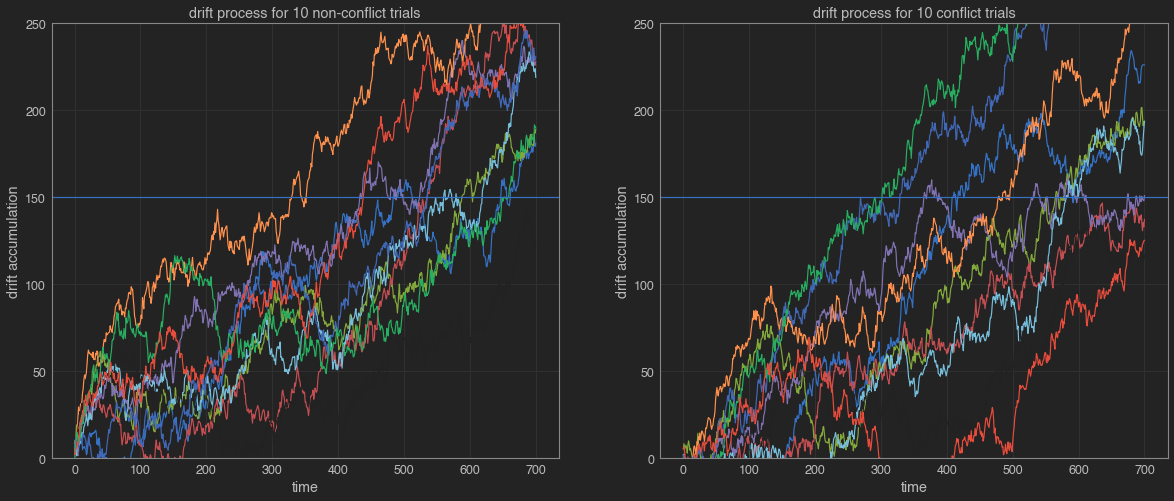

In [5]:
def drift_visualizer(a, tau, sigma, mu_c, A, tmax = 2000, dt = 1) :
    '''visualize drift accumulation process'''
    c = 0
    time = np.arange(dt, tmax + 1, 1)
    mu = A * np.exp(-time / tau) * ((np.exp(1) * time)/((a-1) * tau))**(a-1) * (((a-1)/time) - (1/tau)) + mu_c
    dX = mu*dt + sigma * np.sqrt(dt) * np.random.randn(len(time))

    X = np.cumsum(dX) 
    return X

a = 2 ; tau = 35 ; sigma = 3 ; mu_c = .3 ; A = 20 ; b = 150; n = 10 ; time_vec = np.linspace(0, 700, 701)
_, ax = plt.subplots(1, 2, figsize = (20, 8)) 
for i in range(n) :
    'n non-conflict trials'
    ax[0].plot(time_vec, drift_visualizer(a, tau, sigma, mu_c, A, tmax = 701))
ax[0].set_title('drift process for 10 non-conflict trials')
ax[0].set_xlabel('time')
ax[0].set_ylabel('drift accumulation')
ax[0].axhline(b)# line indicating boundary
ax[0].set_ylim(0, 250)
for i in range(n) : 
    'n conflict trials'
    ax[1].plot(time_vec, drift_visualizer(a, tau, sigma, mu_c, -A, tmax = 701))
ax[1].set_title('drift process for 10 conflict trials')
ax[1].set_xlabel('time')
ax[1].set_ylabel('drift accumulation')
ax[1].axhline(b)
ax[1].set_ylim(0, 250)

#### As mentioned above, in the regular DDM, an increase in drift rate leads to a decrease in both reaction time and standard deviation. In our study, however, we found that introducing an intrusive, task irrelevant stimulus to each trial increased mean reaction time, but decreased standard deviation. Here, we visualize both the effect of a change in drift rate (mu_c in this model) and a change in the sign of the amplitude on the entire reaction time distribution. 

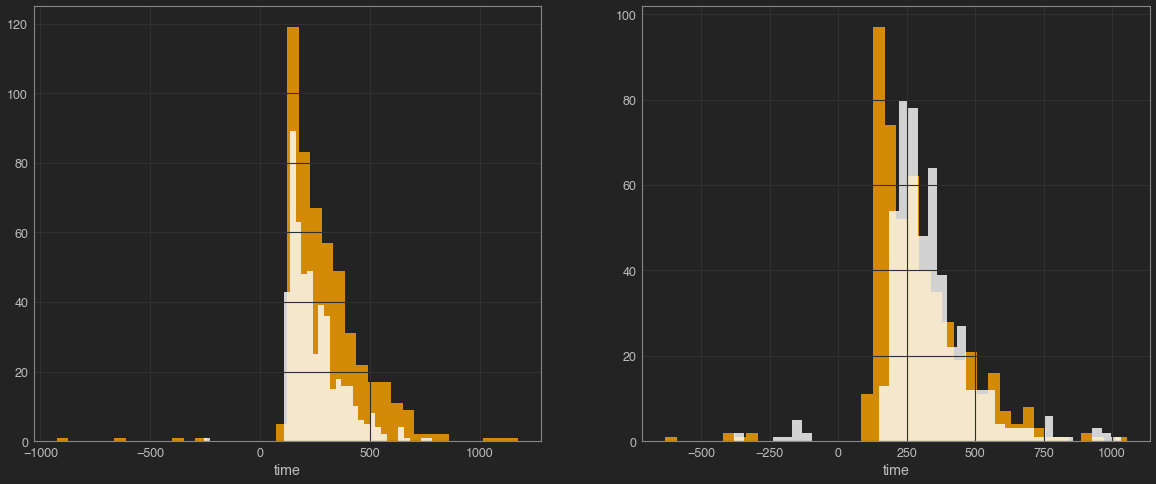

In [6]:
drift_1 = rt_sim(2, 35, 3, .3, 30, 70, 100) 
drift_2 = rt_sim(2, 35, 3, .4, 30, 70, 100)
non_conflict = rt_sim(2, 35, 3, .3, 30, 70, 100)
conflict = rt_sim(2, 35, 3, .3, -30, 70, 100)
change_drift = [drift_1, drift_2]
change_conflict = [non_conflict, conflict]
colors = ['orange', 'white']

_, ax = plt.subplots(1, 2, figsize = (20, 8)) 
for i in range (2) : 
    ax[0].hist(change_drift[i], alpha = 0.8, bins = 40, color = colors[i])
    ax[1].hist(change_conflict[i], alpha = 0.8, bins = 40, color = colors[i])
for i in range(2): 
    ax[i].set_xlabel('time')

In [8]:
like_free = pm.Model()
with like_free : 
    alpha = pm.Normal('a', mu = 2, sd = 1, testval = 2)
    tau = pm.Normal('tau', mu = 35, sd = 15, testval = 35)
    sigma = pm.Normal('sigma', mu = 4, sd = 2, testval = 4)
    A = pm.Normal('A', mu = 20, sd = 5)
    mu_c = pm.Normal('mu_c', mu = 0.3, sd = .1)
    b = pm.Normal('b', mu = 80, sd = 20)
    t = pm.Normal('t', mu = 100, sd = 20)
    like = pm.Simulator(
        'like', rt_sim, observed = non_conflict) 
    trace = pm.sample_smc(kernel = 'ABC')

Sample initial stage: ...
/Users/albertwakhloo/opt/anaconda3/envs/pymc37/lib/python3.7/site-packages/pymc3/smc/smc.py:120: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.298
Stage:   2 Beta: 0.003 Steps:  13 Acce: 0.266
Stage:   3 Beta: 0.008 Steps:  14 Acce: 0.220
Stage:   4 Beta: 0.021 Steps:  18 Acce: 0.174
Stage:   5 Beta: 0.046 Steps:  24 Acce: 0.138
Stage:   6 Beta: 0.091 Steps:  25 Acce: 0.084
Stage:   7 Beta: 0.165 Steps:  25 Acce: 0.049
Stage:   8 Beta: 0.281 Steps:  25 Acce: 0.024
Stage:   9 Beta: 0.504 Steps:  25 Acce: 0.008
Stage:  10 Beta: 0.796 Steps:  25 Acce: 0.003
Stage:  11 Beta: 1.000 Steps:  25 Acce: 0.001


/Users/albertwakhloo/opt/anaconda3/envs/pymc37/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc37/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc37/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc37/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,2.004,0.437,1.729,2.973,0.014,0.010,955.0,955.0,963.0,923.0,NaN
tau,40.180,7.444,29.730,47.419,0.237,0.168,988.0,988.0,979.0,1011.0,NaN
sigma,3.694,0.457,2.582,4.084,0.015,0.010,983.0,980.0,980.0,1034.0,NaN
A,30.688,4.936,19.566,35.120,0.164,0.116,911.0,911.0,914.0,914.0,NaN
mu_c,0.352,0.044,0.247,0.376,0.001,0.001,974.0,970.0,928.0,1039.0,NaN
b,81.768,9.793,59.361,88.188,0.316,0.225,959.0,951.0,980.0,1013.0,NaN
t,93.491,4.360,83.216,100.209,0.140,0.099,973.0,973.0,1001.0,830.0,NaN


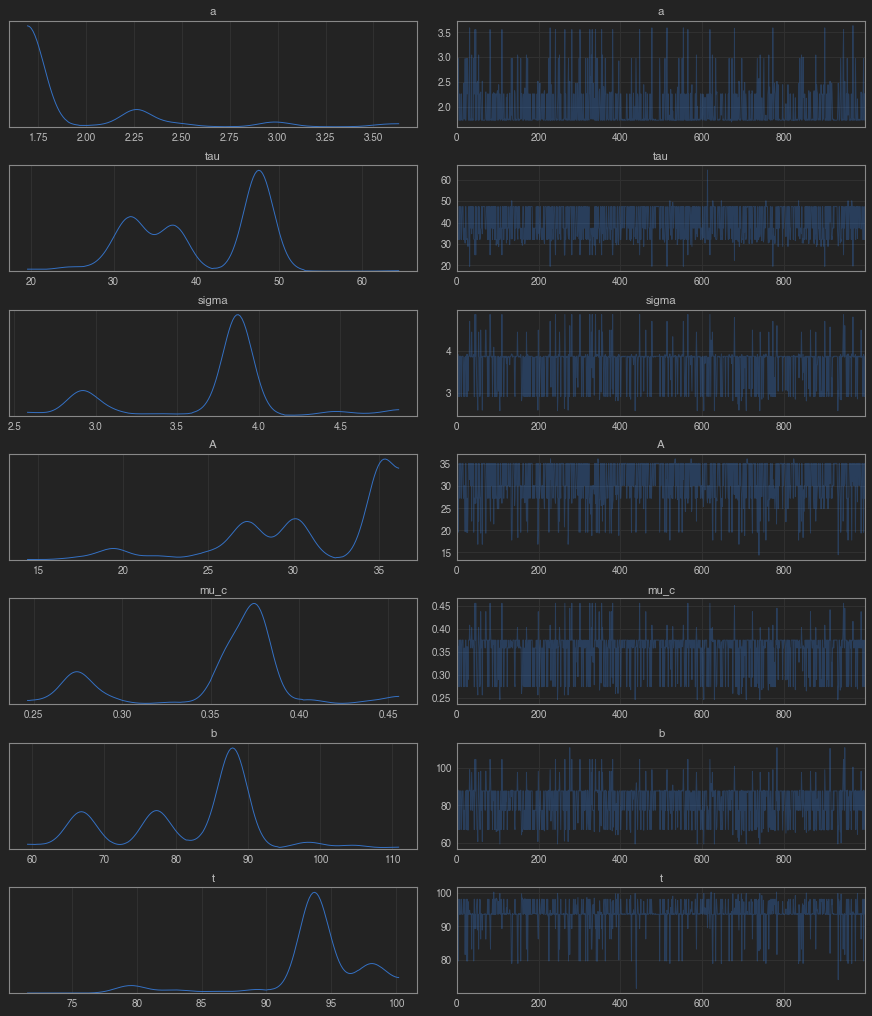

In [9]:
az.plot_trace(trace)
pm.summary(trace)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  0.,  2.,  2.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 69., 94., 70., 71., 50., 72., 56., 53., 48., 49., 35., 32.,
        33., 28., 31., 17., 23., 26., 19., 14., 11., 14.,  9.,  9.,  7.,
         7.,  8.,  7.,  3.,  2.,  1.,  1.,  5.,  3.,  0.,  3.,  0.,  0.,
         2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-730.97564352, -709.82990151, -688.6841595 , -667.5384175 ,
        -646.39267549, -625.24693348, -604.10119147, -582.95544946,
        -561.80970745, -540.66396544, -519.51822343, -498.37248142,
        -477.22673941, -456.0809974 , -434.93525539, -413.78951339,
        -392.64377138, -371.49802937, -350.35228736, -329.20654535,
        -308.06080334, -286.91506133, -265.76931932, -244.62357731,
        -223.4778353 , -20

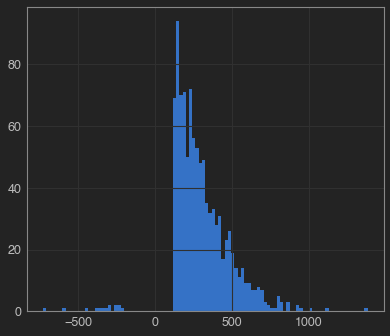

In [24]:
def posterior_predictive(trace, sample) :
    '''push trace samples thru equations'''
    pred = []
    for i in range(sample) :
        pred.append(reaction_time(trace['a'][i], trace['tau'][i], trace['sigma'][i], trace['mu_c'][i], \
                                  trace['A'][i], trace['b'][i], trace['t'][i])) 
    return pred
pred = posterior_predictive(trace, 1000)
plt.hist(pred, bins = 100)